# Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense,Bidirectional 
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

# Sample data
data = pd.read_csv('Houseprice.csv')
data

,Date,Region ID,Region Name,Region Type,State Name,Home Value Index,Size Rank
0,7/31/03,395162,"Torrington, CT",msa,CT,206829.9543,236
1,8/31/03,395162,"Torrington, CT",msa,CT,209576.4668,236
2,9/30/03,395162,"Torrington, CT",msa,CT,212398.5270,236
3,10/31/03,395162,"Torrington, CT",msa,CT,215175.9703,236
4,11/30/03,395162,"Torrington, CT",msa,CT,217573.4558,236
...,...,...,...,...,...,...,...
255965,3/31/17,394776,"Laurel, MS",msa,MS,107746.9037,434
255966,3/31/17,395124,"Starkville, MS",msa,MS,169984.2309,529
255967,3/31/17,394490,"Columbus, MS",msa,MS,125443.1976,543
255968,3/31/17,394977,"Picayune, MS",msa,MS,150324.7686,559


# Loading and Preprocessing Data

In [2]:
data = data[data['Region Name'] == 'Salt Lake City, UT']
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
df = pd.DataFrame(data)
df

,Date,Region ID,Region Name,Region Type,State Name,Home Value Index,Size Rank
163600,2000-01-31,395053,"Salt Lake City, UT",msa,UT,173370.8057,48
163605,2000-02-29,395053,"Salt Lake City, UT",msa,UT,173473.7350,48
163610,2000-03-31,395053,"Salt Lake City, UT",msa,UT,173659.8637,48
163615,2000-04-30,395053,"Salt Lake City, UT",msa,UT,174086.9221,48
163620,2000-05-31,395053,"Salt Lake City, UT",msa,UT,175910.0283,48
...,...,...,...,...,...,...,...
165005,2023-06-30,395053,"Salt Lake City, UT",msa,UT,524735.4525,48
165010,2023-07-31,395053,"Salt Lake City, UT",msa,UT,526616.8991,48
165015,2023-08-31,395053,"Salt Lake City, UT",msa,UT,528841.3976,48
165020,2023-09-30,395053,"Salt Lake City, UT",msa,UT,530407.2567,48


# Data Exploration and Preparation

In [3]:
df = df[['Date', 'Home Value Index']]
df

,Date,Home Value Index
163600,2000-01-31,173370.8057
163605,2000-02-29,173473.7350
163610,2000-03-31,173659.8637
163615,2000-04-30,174086.9221
163620,2000-05-31,175910.0283
...,...,...
165005,2023-06-30,524735.4525
165010,2023-07-31,526616.8991
165015,2023-08-31,528841.3976
165020,2023-09-30,530407.2567


# Data Normalization and Train-Test Split

In [4]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Splitting data into training and testing
train_size = int(len(scaled_data) * 0.9)
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# Convert array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Reshape into X=t and Y=t+1
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Creating Bi-LSTM Model


In [5]:
# Create Bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(1, look_back))))  
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=15)

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=1, validation_data=(X_test, Y_test), callbacks=[early_stop], verbose=1)


Epoch 1/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.1157
Epoch 2/100
255/255 [==============================] - 0s 723us/step - loss: 0.0027 - val_loss: 6.5807e-04
Epoch 3/100
255/255 [==============================] - 0s 689us/step - loss: 6.3913e-05 - val_loss: 0.0034
Epoch 4/100
255/255 [==============================] - 0s 701us/step - loss: 2.2577e-05 - val_loss: 0.0035
Epoch 5/100
255/255 [==============================] - 0s 680us/step - loss: 2.2789e-05 - val_loss: 0.0029
Epoch 6/100
255/255 [==============================] - 0s 678us/step - loss: 2.2485e-05 - val_loss: 0.0033
Epoch 7/100
255/255 [==============================] - 0s 680us/step - loss: 2.1418e-05 - val_loss: 0.0039
Epoch 8/100
255/255 [==============================] - 0s 668us/step - loss: 2.2146e-05 - val_loss: 0.0026
Epoch 9/100
255/255 [==============================] - 0s 665us/step - loss: 2.2981e-05 - val_loss: 0.0042
Epoch 10/100
255/255 [=====================

In [6]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 [==============================] - 0s 8ms/step


# Making Predictions and Evaluating the Model


In [7]:
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform([Y_test])

In [8]:
# Calculate root mean squared error
train_rmse = np.sqrt(np.mean((train_predict[:,0] - Y_train_inv[0])**2))
test_rmse = np.sqrt(np.mean((test_predict[:,0] - Y_test_inv[0])**2))

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 2248.327033754841
Test RMSE: 11364.272017978668


In [9]:
# Adjusting indices to match the length of the predictions
train_index_end = train_size + look_back - 2
test_index_start = train_size + look_back
test_index_end = len(df) - 1

train_predict_df = pd.DataFrame(train_predict, index=df.index[look_back:train_index_end], columns=['Predicted'])
train_actual_df = pd.DataFrame(Y_train_inv.T, index=df.index[look_back:train_index_end], columns=['Actual'])

test_predict_df = pd.DataFrame(test_predict, index=df.index[test_index_start:test_index_end], columns=['Predicted'])
test_actual_df = pd.DataFrame(Y_test_inv.T, index=df.index[test_index_start:test_index_end], columns=['Actual'])


# Visualizing Training Results


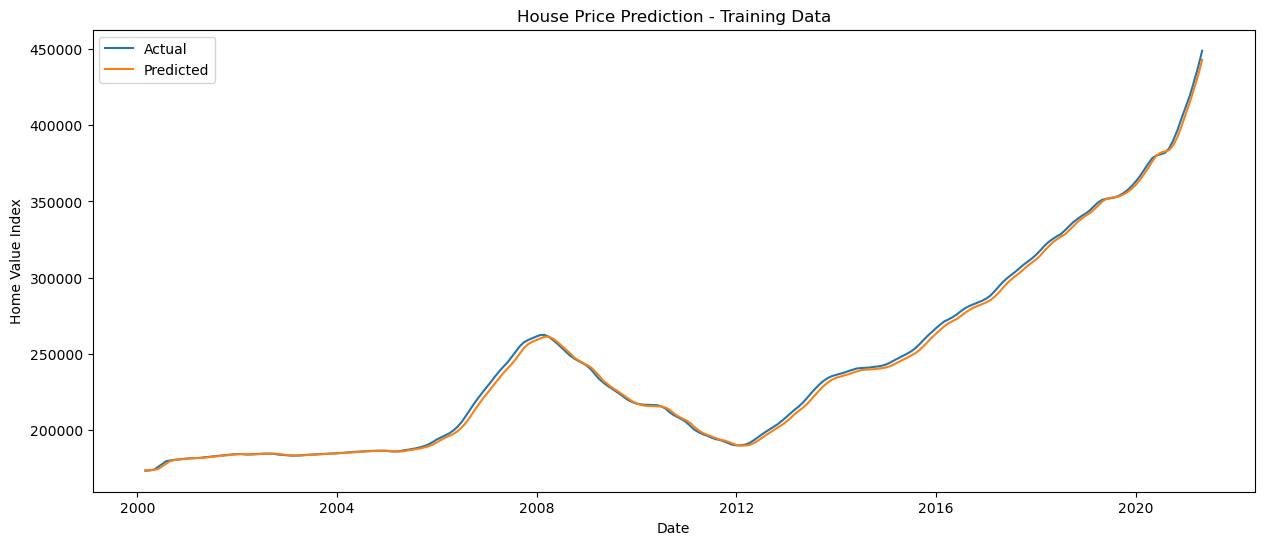

In [10]:
# Plotting Train Data
plt.figure(figsize=(15, 6))
plt.plot(train_actual_df, label='Actual')
plt.plot(train_predict_df, label='Predicted')
plt.title('House Price Prediction - Training Data')
plt.xlabel('Date')
plt.ylabel('Home Value Index')
plt.legend()
plt.show()

# Visualizing Testing Results


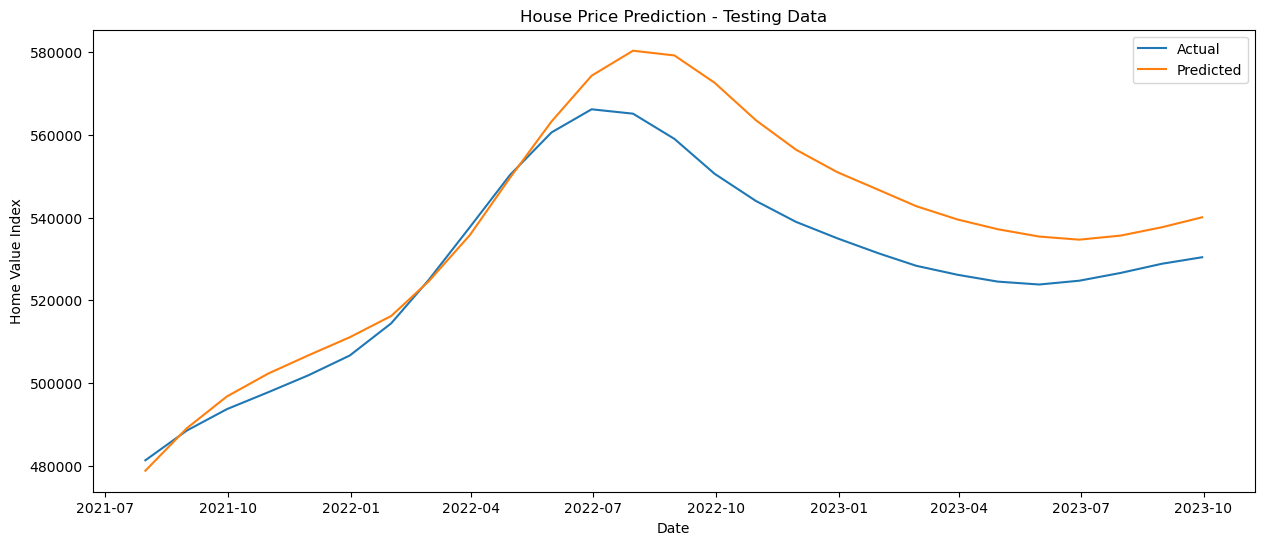

In [11]:
# Plotting Test Data
plt.figure(figsize=(15, 6))
plt.plot(test_actual_df, label='Actual')
plt.plot(test_predict_df, label='Predicted')
plt.title('House Price Prediction - Testing Data')
plt.xlabel('Date')
plt.ylabel('Home Value Index')
plt.legend()
plt.show()


# Generating Future Predictions


In [12]:
# Assuming look_back = 1 as used earlier
future_months = 24
future_predictions = []
current_input = scaled_data[-look_back:]  # Start with the last known data

for _ in range(future_months):
    # Predict the next step and reshape input for the model
    next_prediction = model.predict(current_input.reshape((1, 1, look_back)))
    
    # Append the prediction
    future_predictions.append(next_prediction[0, 0])
    
    # Update the input sequence
    current_input = np.array([next_prediction[0, 0]])

# Inverse transform to get actual value predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Adjust the date generation to reflect monthly steps
last_date = df.index[-1]
prediction_dates = pd.date_range(start=last_date, periods=future_months, freq='MS')
future_df = pd.DataFrame(future_predictions, index=prediction_dates, columns=['Predicted Future Value'])

print(future_df)


1/1 [==============================] - 0s 8ms/step
            Predicted Future Value
2023-11-01            5.433886e+05
2023-12-01            5.557343e+05
2024-01-01            5.690544e+05
2024-02-01            5.834411e+05
2024-03-01            5.989947e+05
2024-04-01            6.158233e+05
2024-05-01            6.340425e+05
2024-06-01            6.537741e+05
2024-07-01            6.751446e+05
2024-08-01            6.982819e+05
2024-09-01            7.233109e+05
2024-10-01            7.503474e+05
2024-11-01            7.794898e+05
2024-12-01            8.108089e+05
2025-01-01            8.443348e+05
2025-02-01            8.800412e+05
2025-03-01            9.178320e+05
2025-04-01            9.575237e+05
2025-05-01            9.988356e+05
2025-06-01            1.041384e+06
2025-07-01            1.084686e+06
2025-08-01            1.128175e+06
2025-09-01            1.171229e+06
2025-10-01            1.213211e+06


# Visualizing Test Data and Future Predictions


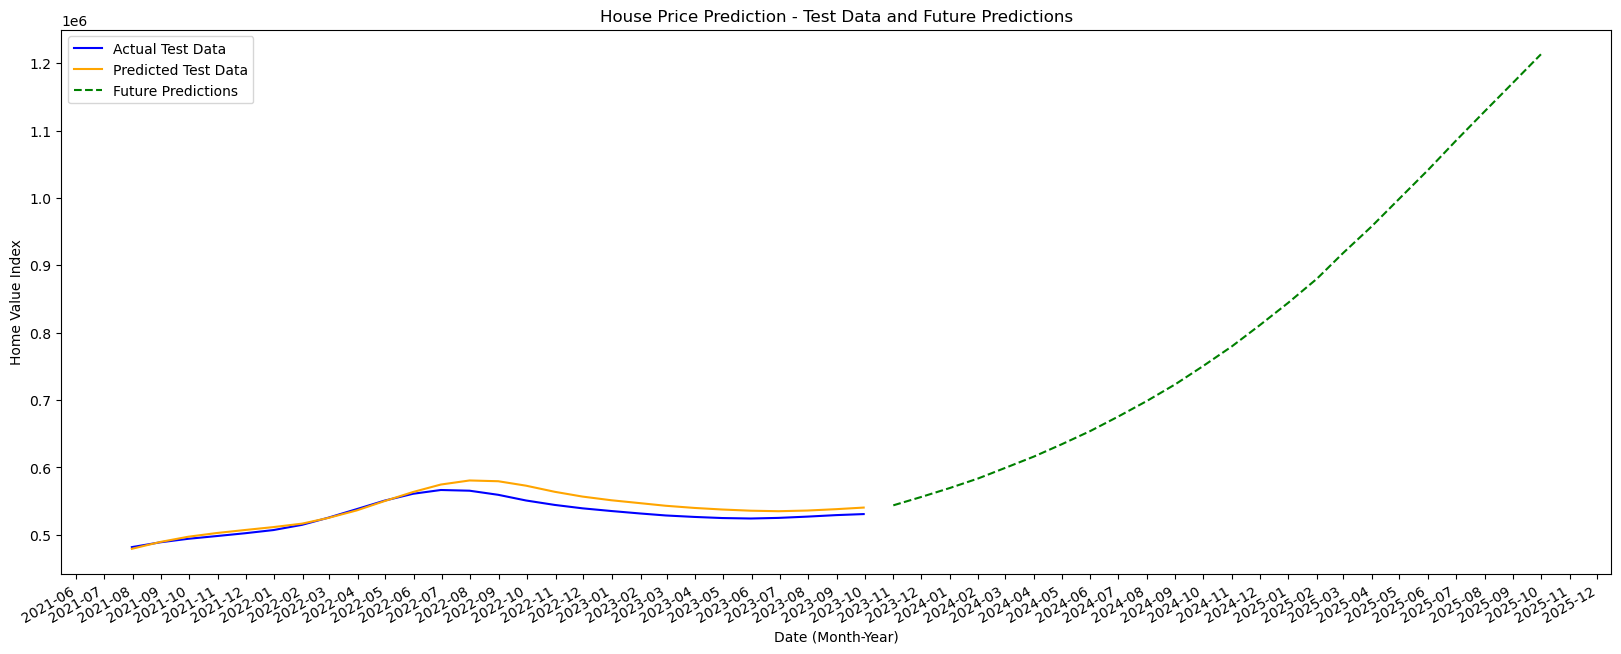

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plotting Test Data and Future Predictions
plt.figure(figsize=(20, 8))

# Plot actual and predicted test data
plt.plot(test_actual_df, label='Actual Test Data', color='blue')
plt.plot(test_predict_df, label='Predicted Test Data', color='orange')

# Plot future predictions
plt.plot(future_df, label='Future Predictions', color='green', linestyle='dashed')

# Formatting the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()  # Rotate date labels

plt.title('House Price Prediction - Test Data and Future Predictions')
plt.xlabel('Date (Month-Year)')
plt.ylabel('Home Value Index')
plt.legend()
plt.show()
